# Travaux Pratiques TP 2
-------------

# AES Execution on STM32F303 and Power Traces Re-Alignment

# TO DO
------------
We'll be collecting traces of our usual implementation of AES in this lab, with one small modification. If we use the EXTRA_OPTS=ADD_JITTER, a for loop that runs between 0 and 15 times through will be inserted:

```C
  #ifdef ADD_JITTER
  for (volatile uint8_t k = 0; k < (*pt & 0x0F); k++);
  #endif
```

As you can see, this jitter is actually based on the first byte of our plaintext. This in itself is a vulnerability. We won't use this fact, but as an exercise, try hypothocizing some ways to use this to overcome the jitter.

------------

---

---

First you'll need to select which hardware setup you have. 

You'll need to select a `SCOPETYPE`, a `PLATFORM`, and a `CRYPTO_TARGET`. 
* `SCOPETYPE` is `'OPENADC'` for the CWLite
* `PLATFORM` is the target device, with `'CWLITEARM'`
* `CRYPTO_TARGET` selects the crypto implementation, with `'TINYAES128C'` working on all platforms. 

For example:

```python
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'
```

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'

The following code will build the firmware for the target.

<img src='images/DoIt.png' style='width: 100px'>

## INDICATE BELOW IN YOUR NOTEBOOK THE RIGHT PATH TO `Setup_Scripts/Setup_Generic.ipynb` on YOUR MACHINE

In [2]:
%run "../../Jupyter3/chipwhisperer/jupyter/Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


<img src='images/DoIt.png' style='width: 100px'>

## SAME: INDICATE BELOW IN YOUR NOTEBOOK THE RIGHT PATH TO `hardware/victims/firmware/simpleserial-aes` on YOUR MACHINE

In [3]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../../Jupyter3/chipwhisperer/hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2 EXTRA_OPTS=ADD_JITTER SS_VER=$3

Building for platform CWLITEARM with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
/Library/Developer/CommandLineTools/usr/bin/make clean_objs .dep 
Building for platform CWLITEARM with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
rm -f -- simpleserial-aes-CWLITEARM.hex
rm -f -- simpleserial-aes-CWLITEARM.eep
rm -f -- simpleserial-aes-CWLITEARM.cof
rm -f -- simpleserial-aes-CWLITEARM.elf
rm -f -- simpleserial-aes-CWLITEARM.map
rm -f -- simpleserial-aes-CWLITEARM.sym
rm -f -- simpleserial-aes-CWLITEARM.lss
rm -f -- objdir-CWLITEARM/*.o
rm -f -- objdir-CWLITEARM/*.lst
rm -f -- simpleserial-aes.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s aes.s aes-independant.s
rm -f -- simpleserial-aes.d simpleserial.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d aes.d aes-independant.d
rm -f -- simpleserial-aes.i simpleserial.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sy

simpleserial-aes.c: In function 'get_pt':
simpleserial-aes.c:44:3: warning: this 'for' clause does not guard... [-Wmisleading-indentation]
   44 |   for (volatile uint8_t k = 0; k < (*pt & 0x0F); k++);
      |   ^~~
simpleserial-aes.c:47:2: note: ...this statement, but the latter is misleadingly indented as if it were guarded by the 'for'
   47 |  aes_indep_enc(pt); /* encrypting the data block */
      |  ^~~~~~~~~~~~~


<img src='images/DoIt.png' style='width: 100px'>

## SAME: INDICATE BELOW IN YOUR NOTEBOOK THE RIGHT PATH TO `hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex` on YOUR MACHINE

In [4]:
cw.program_target(scope, prog, "../../Jupyter3/chipwhisperer/hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6283 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6283 bytes


---------
## Run an AES computation and collect the power trace

In [5]:
import numpy as np
import time

In [6]:
ktp = cw.ktp.Basic()

In [7]:
# Generate plaintext and key for the AES execution
key, plaintext = ktp.next()

# Set the AES key for the target
target.set_key(key)

# Send the plaintext to encrypt
target.simpleserial_write('p', plaintext)

# Define the number of samples to collect into the trace
scope.adc.samples = 5_000

# Arm the scope for trace acquisition
scope.arm()

# Run the AES
ret = scope.capture()
if ret:
    print("Target timed out!")

#Store the result
ciphertext_returned = np.array(target.simpleserial_read('r', 16))

#Store the trace collected
trace = np.array(scope.get_last_trace())

#### Print the plaintext used

In [8]:
plaintext

CWbytearray(b'12 e5 c9 82 3a 0a 35 ad 9a 75 b0 63 8c c2 10 b1')

#### Print the ciphertext returned by the board

In [9]:
ciphertext_returned

array([231, 165,   9,  97, 118,  46,  72, 161,  10, 219, 127, 146,  42,
       180,  26,  88], dtype=uint8)

### Print the points of the trace

* What is the trace length? how many points?



In [10]:
trace

array([ 0.09960938, -0.08105469, -0.04980469, ...,  0.08203125,
        0.125     ,  0.11914062])

In [11]:
len(trace)

5000

<img src='images/DoIt.png' style='width: 100px'>

### Plot the AES traces captured

In [12]:
import matplotlib.pylab as plt

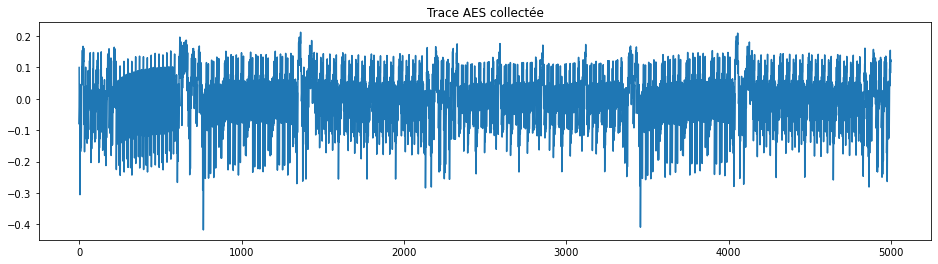

In [13]:
#%matplotlib
plt.rcParams['figure.figsize']=(16,4)
plt.title('Trace AES collectée')
plt.plot(trace)
plt.show()

<img src='images/DoIt.png' style='width: 100px'>


## Observe the trace 

Open the trace in full screen, zoom and observe

* What do you see?
* What kind of information do you visualize?


---------

<img src='images/DoIt.png' style='width: 100px'>

## Run several AES executions and collect the corresponding power traces
## Traces Set Collection

In [14]:
from tqdm import tnrange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []
keyin_array = []
response_array = []

key, text = ktp.next()

target.set_key(key)

scope.adc.samples = 8_000
#scope.adc.samples = 24_000


# Number of traces
#N = 2500
N = 100

# Loop for traces collection 
for i in tnrange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    keyin_array.append(key)
    response_array.append(response)
    
    key, text = ktp.next() 

/Users/bfeix/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


In [15]:
plaintext_np_array = np.array(textin_array)

In [16]:
ciphertext_np_array = np.array(response_array)

In [17]:
key_np_array = np.array(keyin_array)

In [18]:
traces_np_array = np.array(trace_array)

<img src='images/DoIt.png' style='width: 100px'>


### Plot 10 traces and their first 1000 points

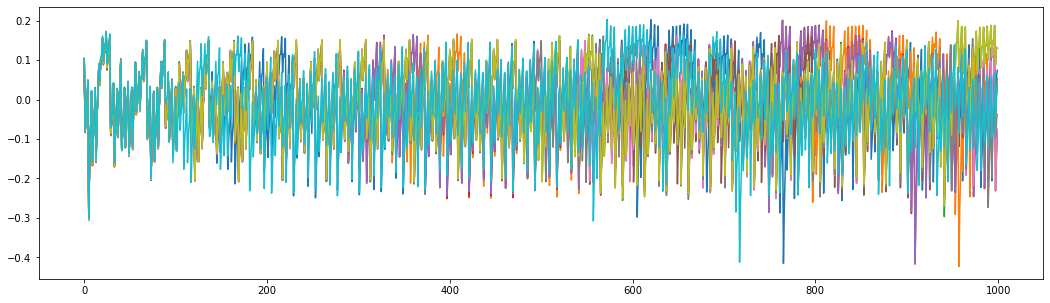

In [19]:
plt.rcParams['figure.figsize']=(18,5)
for i in range(10):
    plt.plot(trace_array[i][0:1000])
plt.show()

### Compute the mean and the standard deviation on the set of collected traces

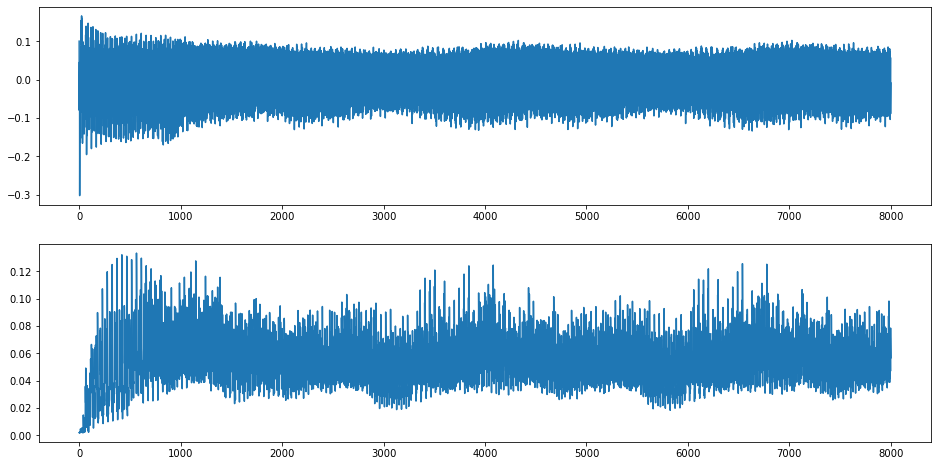

In [20]:
plt.rcParams['figure.figsize']=(16,8)
trace_mean = np.mean(trace_array[0:100], axis = 0)
trace_std = np.std(trace_array[0:100], axis = 0)
plt.subplot(2,1,1) 
plt.plot(trace_mean)
plt.subplot(2,1,2) 
plt.plot(trace_std)
plt.show()

## WHAT DO YOU OBSERVE HERE ?

<img src='images/DoIt.png' style='width: 100px'>

-----------


In [21]:
import estraces

In [22]:
ths = estraces.read_ths_from_ram(samples=traces_np_array, **{'plaintext': plaintext_np_array, 'ciphertext': ciphertext_np_array, 'key' : key_np_array})
print(ths)

Trace Header Set:
Name.............: RAM Format THS
Reader...........: RAM reader with 100 traces. Samples shape: (100, 8000) and metadatas: ['plaintext', 'ciphertext', 'key']
plaintext........: uint8
ciphertext.......: uint8
key..............: uint8



----
<img src='images/DoIt.png' style='width: 100px'>

## Reverse on intermediate values - First round

In [23]:
import scared

In [24]:
def aes_function_firstRde_SBout(plaintext, key):
    return scared.aes.encrypt(plaintext = plaintext, key = key, at_round=1, after_step=scared.aes.base.Steps.SUB_BYTES)

In [25]:
container = scared.Container(ths)

In [26]:
Selection_function = scared.reverse_selection_function(aes_function_firstRde_SBout)

In [27]:
Reverse_SB = scared.CPAReverse(selection_function = Selection_function, model = scared.HammingWeight())
Reverse_SB.run(container)

In [28]:
Reverse_SB.results.shape

(16, 8000)

### Plot results

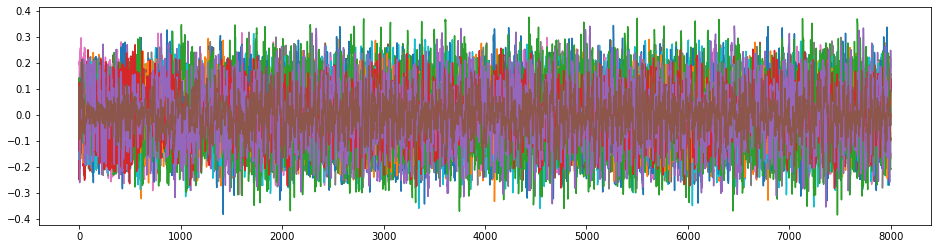

In [29]:
plt.rcParams['figure.figsize']=(16,4)
plt.plot(Reverse_SB.results.T)
plt.show()

<img src='images/DoIt.png' style='width: 100px'>

## What is the issue here? 


Based on the results and the previous plot of traces, mean and variance we understand the traces are misaligned.

We have to resynchronize the traces.

<img src='images/DoIt.png' style='width: 100px'>

------------
## Traces Resynchronization

We observe the traces are only shifted, so a first basic resynchronisation by shifting the trace should be enough

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html#scipy.signal.find_peaks


In [30]:
from scipy.signal import find_peaks

In [31]:
trace = traces_np_array[0]

In [32]:
trace_abs = np.abs(trace)

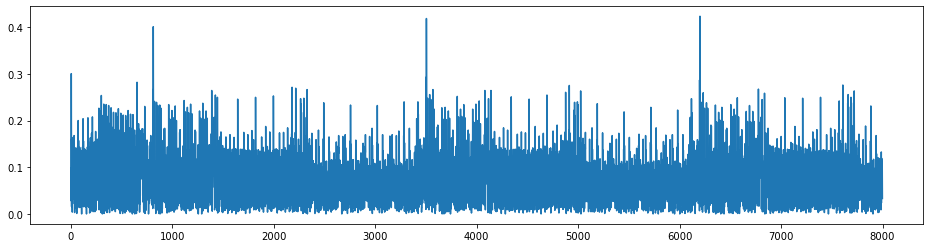

In [45]:
%matplotlib inline
plt.rcParams['figure.figsize']=(16,4)
plt.plot(trace_abs)
plt.show()

In [46]:
peaks, _ = find_peaks(trace_abs, height = 0.35)
peaks

array([ 813, 3505, 6201])

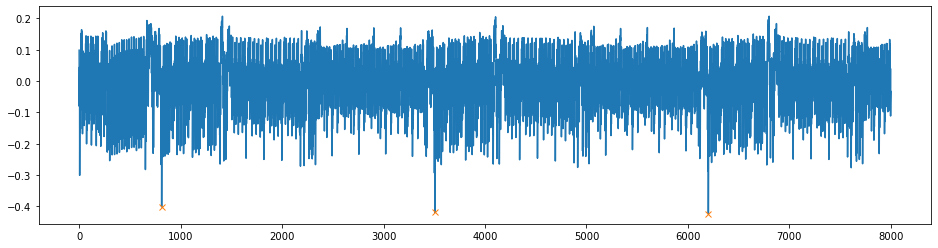

In [47]:
plt.plot(trace)
plt.plot(peaks, trace[peaks], "x")
plt.show()

In [36]:
import tqdm

In [37]:
trace_resync_list = []
for index in tqdm.notebook.trange(len(traces_np_array)):
    trace = traces_np_array[index]
    trace_abs = np.abs(trace)
    peaks, _ = find_peaks(trace_abs, height = 0.32)

    trace_resync_list.append(trace[peaks[0]-500: peaks[0]+3000])

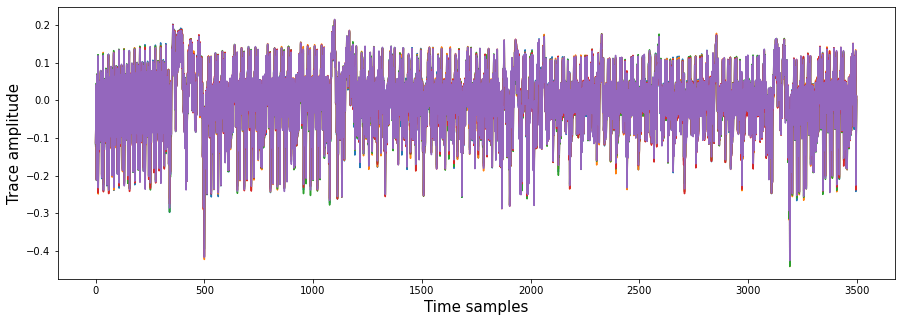

In [38]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(trace_resync_list[0])
ax.plot(trace_resync_list[1])
ax.plot(trace_resync_list[2])
ax.plot(trace_resync_list[3])
ax.plot(trace_resync_list[4])

ax.set_xlabel('Time samples', fontsize=15)
ax.set_ylabel('Trace amplitude', fontsize=15)
plt.plot()
plt.show()

In [39]:
traces_resynchronised = np.array(trace_resync_list)

<img src='images/DoIt.png' style='width: 100px'>

## Now Redo the side-channel reverse analysis

In [40]:
ths = estraces.read_ths_from_ram(samples=traces_resynchronised, **{'plaintext': plaintext_np_array, 'ciphertext': ciphertext_np_array, 'key' : key_np_array})
print(ths)

Trace Header Set:
Name.............: RAM Format THS
Reader...........: RAM reader with 100 traces. Samples shape: (100, 3500) and metadatas: ['plaintext', 'ciphertext', 'key']
plaintext........: uint8
ciphertext.......: uint8
key..............: uint8



In [41]:
container = scared.Container(ths)

In [42]:
Reverse_SB = scared.CPAReverse(selection_function = Selection_function, model = scared.HammingWeight())
Reverse_SB.run(container)

In [43]:
Reverse_SB.results.shape

(16, 3500)

### Plot results

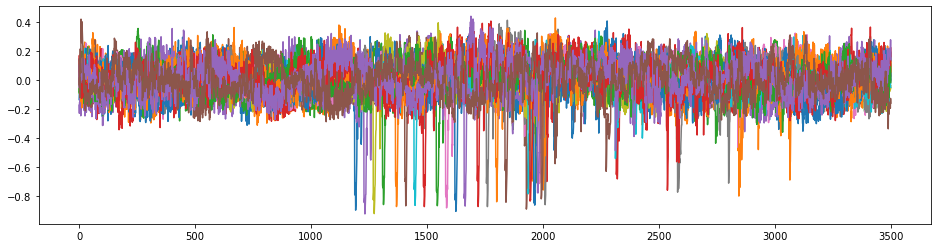

In [44]:
plt.rcParams['figure.figsize']=(16,4)
plt.plot(Reverse_SB.results.T)
plt.show()